# train (Confidential)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 50
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("train_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("train_embeddings.npy", embeddings)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1000/1000 [==============================] - 142s 142ms/sample - loss: nan
Epoch 2/50
1000/1000 [==============================] - 132s 132ms/sample - loss: nan
Epoch 3/50
1000/1000 [==============================] - 132s 132ms/sample - loss: nan
Epoch 4/50
1000/1000 [==============================] - 131s 131ms/sample - loss: nan
Epoch 5/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 6/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 7/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 8/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 9/50
1000/1000 [==============================] - 125s 125ms/sample - loss: nan
Epoch 10/50
10

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("train_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

<Figure size 640x480 with 1 Axes>

# val

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 50
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("val_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("val_embeddings.npy", embeddings)


Epoch 1/50
1000/1000 [==============================] - 139s 139ms/sample - loss: nan
Epoch 2/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 3/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 4/50
1000/1000 [==============================] - 125s 125ms/sample - loss: nan
Epoch 5/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 6/50
1000/1000 [==============================] - 125s 125ms/sample - loss: nan
Epoch 7/50
1000/1000 [==============================] - 125s 125ms/sample - loss: nan
Epoch 8/50
1000/1000 [==============================] - 123s 123ms/sample - loss: nan
Epoch 9/50
1000/1000 [==============================] - 123s 123ms/sample - loss: nan
Epoch 10/50
1000/1000 [==============================] - 122s 122ms/sample - loss: nan
Epoch 11/50
1000/1000 [==============================] - 124s 124ms/sample - loss: nan
Epoch 12/50
1000/1000 [=============================

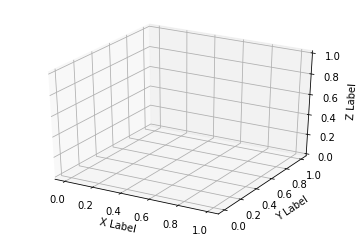

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("val_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# PD_test (PD)

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 50
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("PD_test_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("PD_test_embeddings.npy", embeddings)

Epoch 1/50
1000/1000 [==============================] - 178s 178ms/sample - loss: nan
Epoch 2/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 3/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 4/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 5/50
1000/1000 [==============================] - 164s 164ms/sample - loss: nan
Epoch 6/50
1000/1000 [==============================] - 158s 158ms/sample - loss: nan
Epoch 7/50
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 8/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 9/50
1000/1000 [==============================] - 164s 164ms/sample - loss: nan
Epoch 10/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 11/50
1000/1000 [==============================] - 160s 160ms/sample - loss: nan
Epoch 12/50
1000/1000 [=============================

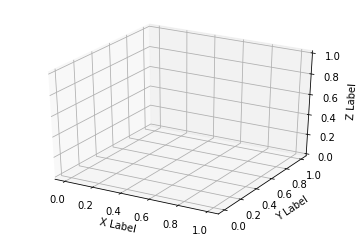

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("PD_test_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# AltPD_test (AltPD)

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 50
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("AltPD_test_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("AltPD_test_embeddings.npy", embeddings)

Epoch 1/50
1000/1000 [==============================] - 176s 176ms/sample - loss: nan
Epoch 2/50
1000/1000 [==============================] - 160s 160ms/sample - loss: nan
Epoch 3/50
1000/1000 [==============================] - 160s 160ms/sample - loss: nan
Epoch 4/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 5/50
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 6/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 7/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 8/50
1000/1000 [==============================] - 159s 159ms/sample - loss: nan
Epoch 9/50
1000/1000 [==============================] - 160s 160ms/sample - loss: nan
Epoch 10/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 11/50
1000/1000 [==============================] - 159s 159ms/sample - loss: nan
Epoch 12/50
1000/1000 [=============================

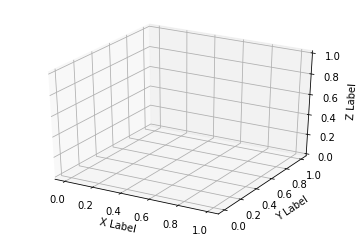

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("AltPD_test_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# outlier

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 50
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("outlier_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("outlier_embeddings.npy", embeddings)

Epoch 1/50
1000/1000 [==============================] - 183s 183ms/sample - loss: nan
Epoch 2/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 3/50
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 4/50
1000/1000 [==============================] - 156s 156ms/sample - loss: nan
Epoch 5/50
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 6/50
1000/1000 [==============================] - 163s 163ms/sample - loss: nan
Epoch 7/50
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 8/50
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 9/50
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 10/50
1000/1000 [==============================] - 159s 159ms/sample - loss: nan
Epoch 11/50
1000/1000 [==============================] - 160s 160ms/sample - loss: nan
Epoch 12/50
1000/1000 [=============================

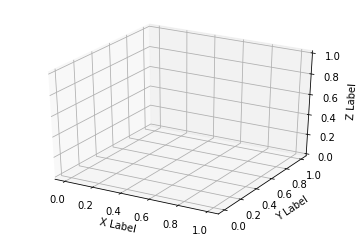

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("outlier_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# uniform (Syn)

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 5
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("uniform_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("uniform_embeddings.npy", embeddings)

Epoch 1/5
1000/1000 [==============================] - 184s 184ms/sample - loss: nan
Epoch 2/5
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 3/5
1000/1000 [==============================] - 163s 163ms/sample - loss: nan
Epoch 4/5
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 5/5
1000/1000 [==============================] - 161s 161ms/sample - loss: nan


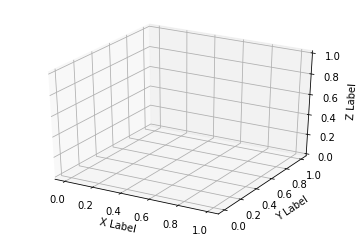

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("uniform_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# advpd

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 10
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("advpd_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("advpd_embeddings.npy", embeddings)

Epoch 1/10
1000/1000 [==============================] - 184s 184ms/sample - loss: nan
Epoch 2/10
1000/1000 [==============================] - 160s 160ms/sample - loss: nan
Epoch 3/10
1000/1000 [==============================] - 160s 160ms/sample - loss: nan
Epoch 4/10
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 5/10
1000/1000 [==============================] - 162s 162ms/sample - loss: nan
Epoch 6/10
1000/1000 [==============================] - 164s 164ms/sample - loss: nan
Epoch 7/10
1000/1000 [==============================] - 161s 161ms/sample - loss: nan
Epoch 8/10
1000/1000 [==============================] - 157s 157ms/sample - loss: nan
Epoch 9/10
1000/1000 [==============================] - 159s 159ms/sample - loss: nan
Epoch 10/10
1000/1000 [==============================] - 161s 161ms/sample - loss: nan


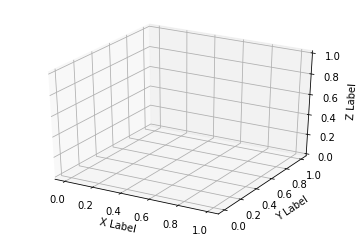

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("advpd_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# img_noise_train (NPD)

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants
IMAGE_SIZE = (128, 128)
LATENT_DIM = 32
BATCH_SIZE = 25
EPOCHS = 100
RECONSTRUCTION_LOSS_MULTIPLIER = 0.5

# Function to load and preprocess images
def load_and_preprocess_images(image_folder):
    image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Load and preprocess images
train_images = load_and_preprocess_images("img_noise_train_dsl")

# Define the encoder part of VAE
encoder_inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = encoder_inputs
for filters in [32, 64, 128, 256]:
    x = layers.Conv2D(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)  # Added dense layer for projection
z_mean = layers.Dense(LATENT_DIM, activation='relu')(x)
z_log_var = layers.Dense(LATENT_DIM, activation='relu')(x)

# Define sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder part of VAE
decoder_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(512, activation='relu')(decoder_inputs)  # Dense layer for decoding
x = layers.Dense(8*8*256, activation='relu')(x)  # Projection
x = layers.Reshape((8, 8, 256))(x)
for filters in [256, 128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 4, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 4, activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = models.Model(encoder_inputs, outputs, name='vae')

# Define the loss function for VAE
def vae_loss(inputs, outputs, z_mean, z_log_var):
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
    reconstruction_loss *= IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = tf.keras.backend.mean(reconstruction_loss + RECONSTRUCTION_LOSS_MULTIPLIER * kl_loss)
    return vae_loss

# Compile the VAE model
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(encoder_inputs, outputs, z_mean, z_log_var))

# Train the VAE model
vae.fit(train_images, train_images, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Extract embeddings from the encoder part
embeddings = encoder.predict(train_images)[0]  # Assuming you want z_mean

# Save or use embeddings as needed
np.save("img_noise_train_embeddings.npy", embeddings)

Epoch 1/100
1000/1000 [==============================] - 189s 189ms/sample - loss: 326580352803598.4375
Epoch 2/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 32608.4166
Epoch 3/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 46805.9935
Epoch 4/100
1000/1000 [==============================] - 161s 161ms/sample - loss: 18638.2864
Epoch 5/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 18038.0042
Epoch 6/100
1000/1000 [==============================] - 164s 164ms/sample - loss: 17862.8890
Epoch 7/100
1000/1000 [==============================] - 161s 161ms/sample - loss: 19134.2695
Epoch 8/100
1000/1000 [==============================] - 157s 157ms/sample - loss: 19802.0757
Epoch 9/100
1000/1000 [==============================] - 161s 161ms/sample - loss: 31966.0940
Epoch 10/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 17500.6628
Epoch 11/100
1000/1000 [=========================

1000/1000 [==============================] - 162s 162ms/sample - loss: 17101.4159
Epoch 88/100
1000/1000 [==============================] - 162s 162ms/sample - loss: 17042.5571
Epoch 89/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 17023.8016
Epoch 90/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 17021.1541
Epoch 91/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 17008.3300
Epoch 92/100
1000/1000 [==============================] - 160s 160ms/sample - loss: 17024.7961
Epoch 93/100
1000/1000 [==============================] - 163s 163ms/sample - loss: 17021.0174
Epoch 94/100
1000/1000 [==============================] - 162s 162ms/sample - loss: 17009.9977
Epoch 95/100
1000/1000 [==============================] - 160s 160ms/sample - loss: 17032.7440
Epoch 96/100
1000/1000 [==============================] - 161s 161ms/sample - loss: 17016.0481
Epoch 97/100
1000/1000 [==============================] - 159s 

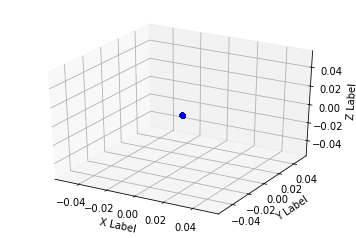

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the embeddings from the .npy file
embeddings = np.load("img_noise_train_embeddings.npy")

# Assuming the embeddings are 3-dimensional
x = embeddings[:, 0]
y = embeddings[:, 1]
z = embeddings[:, 2]

# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

# Plotting

In [17]:
import numpy as np
from multiprocessing import Pool

# Load datasets from the files
true_train_zs = np.load("train_embeddings.npy")
true_val_zs = np.load("val_embeddings.npy")
pd_zs = np.load("PD_test_embeddings.npy")

def base_kernel(x, y, sigma):
    norm_square = np.linalg.norm(x - y) ** 2
    sigma_square = sigma ** 2
    return np.exp(-norm_square / (2 * sigma_square))

def composite_kernel(x, y, sigmas):
    result = 0
    for sigma in sigmas:
        result += base_kernel(x, y, sigma)
    return result

def compute_mmd(dataset_x, dataset_y, sigmas=[1, 5, 10, 15, 20]):
    result = 0
    n = len(dataset_x)
    m = len(dataset_y)
    
    for i in range(n):
        for j in range(n):
            result += 1. / (n ** 2) * composite_kernel(dataset_x[i], dataset_x[j], sigmas)
    
    for i in range(n):
        for j in range(m):
            result -= 2. / (n * m) * composite_kernel(dataset_x[i], dataset_y[j], sigmas)
    
    for i in range(m):
        for j in range(m):
            result += 1. / (m ** 2) * composite_kernel(dataset_y[i], dataset_y[j], sigmas)
    
    return np.sqrt(result)

draws = 20
samples_per_draw = 100

for _ in range(draws):
    train_subs = true_train_zs[np.random.choice(true_train_zs.shape[0], samples_per_draw, replace=False)]

def test_mmd(train, val, test, draws=20):
    res = compute_mmd(train_subs, test)
    return res

def test_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, pd_zs[i+100:i+200])

p = Pool(20)
test_mmds = p.map(test_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

print(test_mmds)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

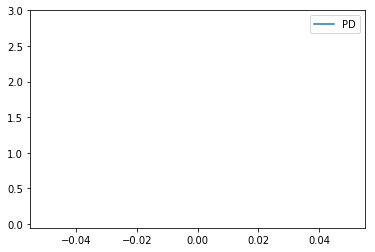

In [18]:
plt.plot(test_mmds)
plt.legend(['PD'])
plt.yticks(np.arange(0.0, 3.1, 0.5))
plt.show()

In [19]:
import numpy as np
from multiprocessing import Pool

# Load datasets from the files
true_train_zs = np.load("train_embeddings.npy")
true_val_zs = np.load("val_embeddings.npy")
pd_zs = np.load("AltPD_test_embeddings.npy")

def base_kernel(x, y, sigma):
    norm_square = np.linalg.norm(x - y) ** 2
    sigma_square = sigma ** 2
    return np.exp(-norm_square / (2 * sigma_square))

def composite_kernel(x, y, sigmas):
    result = 0
    for sigma in sigmas:
        result += base_kernel(x, y, sigma)
    return result

def compute_mmd(dataset_x, dataset_y, sigmas=[1, 5, 10, 15, 20]):
    result = 0
    n = len(dataset_x)
    m = len(dataset_y)
    
    for i in range(n):
        for j in range(n):
            result += 1. / (n ** 2) * composite_kernel(dataset_x[i], dataset_x[j], sigmas)
    
    for i in range(n):
        for j in range(m):
            result -= 2. / (n * m) * composite_kernel(dataset_x[i], dataset_y[j], sigmas)
    
    for i in range(m):
        for j in range(m):
            result += 1. / (m ** 2) * composite_kernel(dataset_y[i], dataset_y[j], sigmas)
    
    return np.sqrt(result)

draws = 20
samples_per_draw = 100

for _ in range(draws):
    train_subs = true_train_zs[np.random.choice(true_train_zs.shape[0], samples_per_draw, replace=False)]

def test_mmd(train, val, test, draws=20):
    res = compute_mmd(train_subs, test)
    return res

def test_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, pd_zs[i+100:i+200])

p = Pool(20)
altpd_test_mmds = p.map(test_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

print(altpd_test_mmds)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

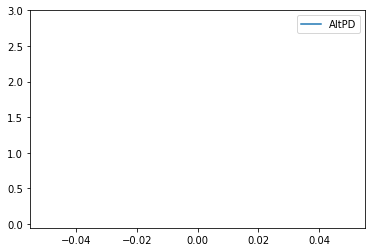

In [20]:
plt.plot(altpd_test_mmds)
plt.legend(['AltPD'])
plt.yticks(np.arange(0.0, 3.1, 0.5))
plt.show()

In [21]:
import numpy as np
from multiprocessing import Pool

# Load datasets from the files
true_train_zs = np.load("train_embeddings.npy")
true_val_zs = np.load("val_embeddings.npy")
uniform_zs = np.load("uniform_embeddings.npy")

def base_kernel(x, y, sigma):
    norm_square = np.linalg.norm(x - y) ** 2
    sigma_square = sigma ** 2
    return np.exp(-norm_square / (2 * sigma_square))

def composite_kernel(x, y, sigmas):
    result = 0
    for sigma in sigmas:
        result += base_kernel(x, y, sigma)
    return result

def compute_mmd(dataset_x, dataset_y, sigmas=[1, 5, 10, 15, 20]):
    result = 0
    n = len(dataset_x)
    m = len(dataset_y)
    
    for i in range(n):
        for j in range(n):
            result += 1. / (n ** 2) * composite_kernel(dataset_x[i], dataset_x[j], sigmas)
    
    for i in range(n):
        for j in range(m):
            result -= 2. / (n * m) * composite_kernel(dataset_x[i], dataset_y[j], sigmas)
    
    for i in range(m):
        for j in range(m):
            result += 1. / (m ** 2) * composite_kernel(dataset_y[i], dataset_y[j], sigmas)
    
    return np.sqrt(result)

draws = 20
samples_per_draw = 100

for _ in range(draws):
    train_subs = true_train_zs[np.random.choice(true_train_zs.shape[0], samples_per_draw, replace=False)]

def test_mmd(train, val, test, draws=20):
    res = compute_mmd(train_subs, test)
    return res

def unif_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, uniform_zs[i+100:i+200])

p = Pool(20)
unif_mmds = p.map(unif_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

print(unif_mmds)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

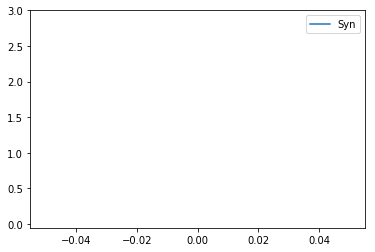

In [22]:
plt.plot(unif_mmds)
plt.legend(['Syn'])
plt.yticks(np.arange(0.0, 3.1, 0.5))
plt.show()

In [23]:
import numpy as np
from multiprocessing import Pool

# Load datasets from the files
true_train_zs = np.load("train_embeddings.npy")
true_val_zs = np.load("val_embeddings.npy")
advpd_zs = np.load("advpd_embeddings.npy")

def base_kernel(x, y, sigma):
    norm_square = np.linalg.norm(x - y) ** 2
    sigma_square = sigma ** 2
    return np.exp(-norm_square / (2 * sigma_square))

def composite_kernel(x, y, sigmas):
    result = 0
    for sigma in sigmas:
        result += base_kernel(x, y, sigma)
    return result

def compute_mmd(dataset_x, dataset_y, sigmas=[1, 5, 10, 15, 20]):
    result = 0
    n = len(dataset_x)
    m = len(dataset_y)
    
    for i in range(n):
        for j in range(n):
            result += 1. / (n ** 2) * composite_kernel(dataset_x[i], dataset_x[j], sigmas)
    
    for i in range(n):
        for j in range(m):
            result -= 2. / (n * m) * composite_kernel(dataset_x[i], dataset_y[j], sigmas)
    
    for i in range(m):
        for j in range(m):
            result += 1. / (m ** 2) * composite_kernel(dataset_y[i], dataset_y[j], sigmas)
    
    return np.sqrt(result)

draws = 20
samples_per_draw = 100

for _ in range(draws):
    train_subs = true_train_zs[np.random.choice(true_train_zs.shape[0], samples_per_draw, replace=False)]

def test_mmd(train, val, test, draws=20):
    res = compute_mmd(train_subs, test)
    return res

def pap_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, advpd_zs[i+100:i+200])

p = Pool(20)
pap_mmds = p.map(pap_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

print(pap_mmds)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

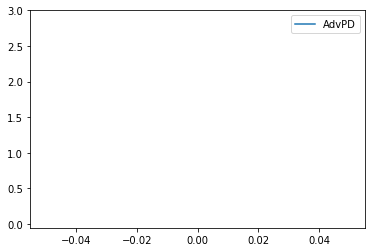

In [24]:
plt.plot(pap_mmds)
plt.legend(['AdvPD'])
plt.yticks(np.arange(0.0, 3.1, 0.5))
plt.show()

In [25]:
import numpy as np
from multiprocessing import Pool

# Load datasets from the files
true_train_zs = np.load("train_embeddings.npy")
true_val_zs = np.load("val_embeddings.npy")
img_noise_zs = np.load("img_noise_train_embeddings.npy")

def base_kernel(x, y, sigma):
    norm_square = np.linalg.norm(x - y) ** 2
    sigma_square = sigma ** 2
    return np.exp(-norm_square / (2 * sigma_square))

def composite_kernel(x, y, sigmas):
    result = 0
    for sigma in sigmas:
        result += base_kernel(x, y, sigma)
    return result

def compute_mmd(dataset_x, dataset_y, sigmas=[1, 5, 10, 15, 20]):
    result = 0
    n = len(dataset_x)
    m = len(dataset_y)
    
    for i in range(n):
        for j in range(n):
            result += 1. / (n ** 2) * composite_kernel(dataset_x[i], dataset_x[j], sigmas)
    
    for i in range(n):
        for j in range(m):
            result -= 2. / (n * m) * composite_kernel(dataset_x[i], dataset_y[j], sigmas)
    
    for i in range(m):
        for j in range(m):
            result += 1. / (m ** 2) * composite_kernel(dataset_y[i], dataset_y[j], sigmas)
    
    return np.sqrt(result)

draws = 20
samples_per_draw = 100

for _ in range(draws):
    train_subs = true_train_zs[np.random.choice(true_train_zs.shape[0], samples_per_draw, replace=False)]

def test_mmd(train, val, test, draws=20):
    res = compute_mmd(train_subs, test)
    return res

def img_mmd_wrapper(i):
    return test_mmd(true_train_zs, true_val_zs, img_noise_zs[i+100:i+200])

p = Pool(20)
img_mmds = p.map(img_mmd_wrapper, [i for i in range(250)])
p.close()
p.join()

print(img_mmds)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

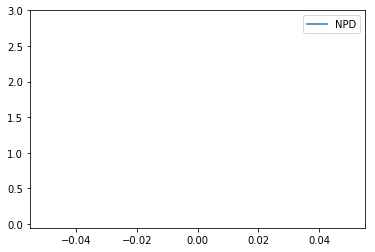

In [26]:
plt.plot(img_mmds)
plt.legend(['NPD'])
plt.yticks(np.arange(0.0, 3.1, 0.5))
plt.show()

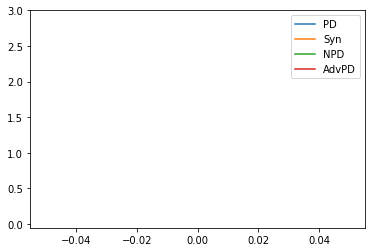

In [27]:
plt.plot(test_mmds)
plt.plot(unif_mmds)
plt.plot(img_mmds)
plt.plot(pap_mmds)

plt.legend(['PD', 'Syn', 'NPD', 'AdvPD'])
plt.yticks(np.arange(0.0, 3.1, 0.5))
plt.show()

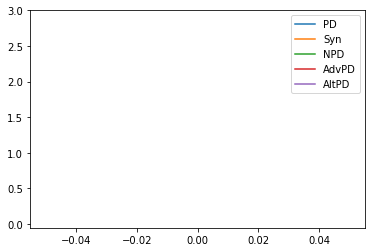

In [28]:
plt.plot(test_mmds)
plt.plot(unif_mmds)
plt.plot(img_mmds)
plt.plot(pap_mmds)
plt.plot(altpd_test_mmds)

plt.legend(['PD', 'Syn', 'NPD', 'AdvPD', 'AltPD'])
plt.yticks(np.arange(0.0, 3.1, 0.5))
plt.show()